<a href="https://www.kaggle.com/code/phoebec216/does-using-ks2-data-to-predict-gcse-grades-work?scriptVersionId=94501453" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predicting-student-grades/AllResults.csv


**Introduction**

The dataset used contains Maths and English GCSE results across 4 years for an unknown English secondary school. It also contains some data on reading, writing, and maths grades from age 10. In addition there is data on whether students have free school meals, whether students count as pupil premium (PP), whether they have English as an Additional Language (EAL) and whether they have any form of Special Educational Need (SEN). (Pupil premium students are students who are, or have been in the last 6 years, in receipt of free school meals, or who are currently or ever have been, in local authority care. Schools receive additional funding to support these students.)

Currently schools / the government use data and results from Key Stage 2 (ages 7-11) to predict the grades received at GCSE level, often resulting in inflated or lowered target grades for students, based on ability at age 10 rather than ability in lead up to exams, and a worse view of the school if the school cannot ensure students reach their predicted grades.

The focus of this analysis will be to determine whether KS2 results are in fact a good predictor of GCSE results or whether they should be viewed as less important, or ignored completely, when predicting target grades at GCSE.

NB: Some of the GCSE grades have decimal values. This is not possible in the current grading system so I am unsure where this data came from. It will be used in the analyses but obviously no interpretations of any analyses should be made without considering the accuracies of the original data.

**Import Libraries**

In [2]:
import numpy as np # linear algebra
import pandas as pd #  data processing, CSV file...
import matplotlib.pyplot as plt # data visualisation
import scipy.stats as stats # statistical hypotheses testing

**Load Data**

In [3]:
df = pd.read_csv("../input/predicting-student-grades/AllResults.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037 entries, 0 to 1036
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PPID       1037 non-null   int64  
 1   PP         1034 non-null   float64
 2   EAL        1037 non-null   int64  
 3   SEN        1033 non-null   float64
 4   HML        987 non-null    object 
 5   Re         917 non-null    object 
 6   Wr         915 non-null    object 
 7   Ma         987 non-null    object 
 8   Att8Est    987 non-null    float64
 9   Att8Act    1036 non-null   float64
 10  Att8Diff   987 non-null    float64
 11  EngEst     987 non-null    float64
 12  EngAct     1036 non-null   float64
 13  EngDiff    987 non-null    float64
 14  MathsEst   987 non-null    float64
 15  MathsAct   1036 non-null   float64
 16  MathsDiff  987 non-null    float64
 17  EbaccEst   987 non-null    float64
 18  EbaccAct   1036 non-null   float64
 19  EbaccDiff  987 non-null    float64
dtypes: float

For this analysis the Attainment 8 and EBacc scores are not needed, nor  are the estimated  grades or the difference so these columns will be removed.

In [4]:
columns_needed = ["PPID","PP","EAL","SEN","HML","Re","Wr","Ma","EngAct","MathsAct"]
df = df[columns_needed]
df.head()

,PPID,PP,EAL,SEN,HML,Re,Wr,Ma,EngAct,MathsAct
0,617,1.0,0,0.0,NaN,NaN,NaN,NaN,1.5,2.0
1,283,1.0,1,0.0,NaN,NaN,NaN,NaN,3.0,5.5
2,75,0.0,0,0.0,M,NaN,NaN,3,4.0,4.0
3,1019,1.0,0,0.0,L,NaN,NaN,3,4.0,3.0
4,474,0.0,0,0.0,L,3C,3B,N,3.0,3.0


**Missing Data**

As can be seen, some rows are missing reading, writing, and maths results from age 10.

Null data in these columns will not be removed from the data now but will be ignored/separated as and when needed.

There is also one null value in both the maths and English GCSE grade columns. This/these rows will be removed now.

In [5]:
df = df.dropna(subset=['EngAct', 'MathsAct'])

**Formatting data**

The age 10 results data needs to be edited to turn it into clear discrete quantitative data.

Specifically, the reading, writing, and maths data needs converted so that the data can be ordered.

*https://www.theschoolrun.com/what-are-national-curriculum-levels* has the clearest definition of the former National levels for assessing progress in key stage 1&2.

Officially there were 24 levels, levels 1-8 split between C, B, and A. 

Therefore the data will be converted such that 1C would become 1 and 8A would become 24 (however, note that there is no data for any student who achieved a level below 2B or above 6A so only these values will actually be converted).

Any  values that are missing the latter part of the grade will be assumed as B (e.g. 4 would be assumed as 4B and converted to 11). Any values that contain only the latter part of the grade (e.g. just "B") will not be converted. Any N values will also not be converted.

In [6]:
level_dict = {"2B":5, "2":5, "2A":6, "3C":7, "3B":8, "3":8, "3A":9, "4C":10, "4B":11, "4":11, "4A":12, "5C":13, "5B":14, "5":14, "5A":15, "6C":16, "6B":17, "6":17, "6A":18}
df["Re_num"] = df["Re"].map(level_dict)
df["Wr_num"] = df["Wr"].map(level_dict)
df["Ma_num"] = df["Ma"].map(level_dict)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1036 entries, 0 to 1036
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PPID      1036 non-null   int64  
 1   PP        1033 non-null   float64
 2   EAL       1036 non-null   int64  
 3   SEN       1032 non-null   float64
 4   HML       987 non-null    object 
 5   Re        917 non-null    object 
 6   Wr        915 non-null    object 
 7   Ma        987 non-null    object 
 8   EngAct    1036 non-null   float64
 9   MathsAct  1036 non-null   float64
 10  Re_num    875 non-null    float64
 11  Wr_num    901 non-null    float64
 12  Ma_num    956 non-null    float64
dtypes: float64(7), int64(2), object(4)
memory usage: 113.3+ KB


In [8]:
df.head(10)

,PPID,PP,EAL,SEN,HML,Re,Wr,Ma,EngAct,MathsAct,Re_num,Wr_num,Ma_num
0,617,1.0,0,0.0,NaN,NaN,NaN,NaN,1.5,2.0,NaN,NaN,NaN
1,283,1.0,1,0.0,NaN,NaN,NaN,NaN,3.0,5.5,NaN,NaN,NaN
2,75,0.0,0,0.0,M,NaN,NaN,3,4.0,4.0,NaN,NaN,8.0
3,1019,1.0,0,0.0,L,NaN,NaN,3,4.0,3.0,NaN,NaN,8.0
4,474,0.0,0,0.0,L,3C,3B,N,3.0,3.0,7.0,8.0,NaN
5,20,0.0,0,0.0,H,5B,5C,5C,7.0,7.0,14.0,13.0,13.0
6,313,0.0,0,0.0,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN
7,443,0.0,0,1.0,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN
8,844,0.0,0,0.0,M,4B,3A,5B,5.5,7.0,11.0,9.0,14.0
9,362,0.0,1,0.0,M,NaN,NaN,4B,5.5,5.5,NaN,NaN,11.0


**Connection between ability level age 10 and GCSE grades**

Firstly let's visualise how ability level (high, medium, and low), determined by age 10 results, relate to GCSE grades in maths and English.

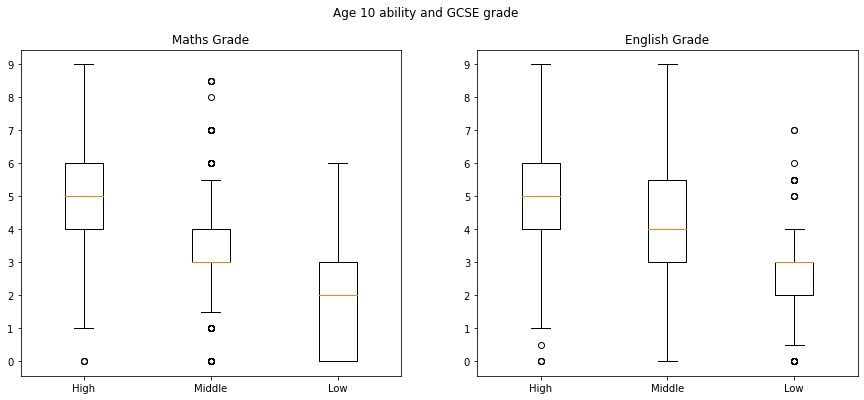

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

plt.suptitle("Age 10 ability and GCSE grade")

# boxplots for maths grade
ax1.boxplot((df['MathsAct'][df['HML']=='H'], df['MathsAct'][df['HML']=='M'], df['MathsAct'][df['HML']=='L']), labels = ['High', 'Middle', 'Low'])
ax1.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax1.set_title("Maths Grade")

#boxplots for English grade
ax2.boxplot((df['EngAct'][df['HML']=='H'], df['EngAct'][df['HML']=='M'], df['EngAct'][df['HML']=='L']), labels = ['High', 'Middle', 'Low'])
ax2.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax2.set_title("English Grade")

plt.show()

The boxplots show that on average people who are determined to be of higher ability at age 10 do achieve better GCSE results, but there is still an extremely high level of spread among the data with some students who had a high ability at age 10 failing (0) at GCSE while others who had low ability achieved a grade 7 (equivalent to a former A grade). 

However, as it is unclear from the data provided how ability at age 10 has actually been calculated, these findings will not be further analysed and instead focus will be put on specific writing, reading and maths levels at age 10.

**Correlations between age 10 results and English GCSE grade**

Now let's look at scatter graphs of the correlations for the relationship between age 10 results and English GCSE grade.

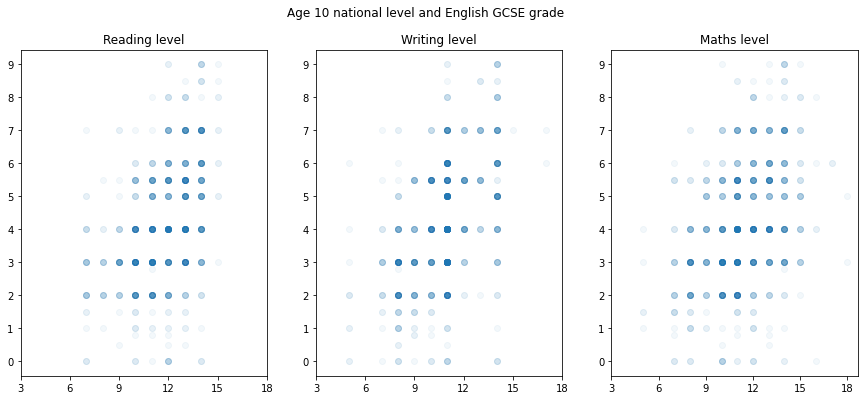

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,6))
plt.suptitle("Age 10 national level and English GCSE grade")
ax1.scatter(df["Re_num"],df["EngAct"], alpha = 0.05)
ax2.scatter(df["Wr_num"],df["EngAct"], alpha = 0.05)
ax3.scatter(df["Ma_num"],df["EngAct"], alpha = 0.05)
ax1.set_title("Reading level")
ax2.set_title("Writing level")
ax3.set_title("Maths level")
ax1.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax2.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax3.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax1.set_xticks([3, 6, 9, 12, 15, 18])
ax2.set_xticks([3, 6, 9, 12, 15, 18])
ax3.set_xticks([3, 6, 9, 12, 15, 18])
plt.show()

There does not appear to be an obvious strong correlation. A Spearman correlation test will be carried out to determine if there is a statistically significant correlation. (Note that Spearman correlation is being used as the grade data is being considered ordinal rather than continuous.)

In [11]:
# convert all the necessary data from the dataframe into separate lists
orig_read = df["Re_num"].tolist()
orig_wri = df["Wr_num"].tolist()
orig_ma = df["Ma_num"].tolist()
orig_eng = df["EngAct"].tolist()

# create new lists containing only data for both age 10 and gcse where age 10 data is not missing
read = []
eng_r = []
for i in range(len(orig_read)):
    if orig_read[i] in level_dict.values():
        read.append(orig_read[i])
        eng_r.append(orig_eng[i])
        
writing = []
eng_w = []
for i in range(len(orig_wri)):
    if orig_wri[i] in level_dict.values():
        writing.append(orig_wri[i])
        eng_w.append(orig_eng[i])

ma = []      
eng_m = []
for i in range(len(orig_ma)):
    if orig_ma[i] in level_dict.values():
        ma.append(orig_ma[i])
        eng_m.append(orig_eng[i])           


In [12]:
# Spearman rho correlation test

print("Reading:")
coef, p = stats.spearmanr(read,eng_r)
print(f'Spearmans correlation coefficient: {round(coef, 3)}')
# interpret the significance
alpha = 0.05
if p > alpha:
    print(f'Samples are uncorrelated (fail to reject H0) p={round(p, 3)}')
else:
    if p >= 0.00001:
        print(f'Samples are correlated (reject H0) p={round(p*100, 3)}%')
    else:
        print(f'Samples are correlated (reject H0) p<0.001%')
    
print("\n")
    
print("Writing:")
coef, p = stats.spearmanr(writing,eng_w)
print(f'Spearmans correlation coefficient: {round(coef, 3)}')
# interpret the significance
alpha = 0.05
if p > alpha:
    print(f'Samples are uncorrelated (fail to reject H0) p={round(p, 3)}')
else:
    if p >= 0.00001:
        print(f'Samples are correlated (reject H0) p={round(p*100, 3)}%')
    else:
        print(f'Samples are correlated (reject H0) p<0.001%')
    
print("\n")
    
print("Maths:")
coef, p = stats.spearmanr(ma, eng_m)
print(f'Spearmans correlation coefficient: {round(coef, 3)}')
# interpret the significance
alpha = 0.05
if p > alpha:
    print(f'Samples are uncorrelated (fail to reject H0) p={round(p*100, 3)}%')
else:
    if p >= 0.00001:
        print(f'Samples are correlated (reject H0) p={round(p*100, 3)}%')
    else:
        print(f'Samples are correlated (reject H0) p<0.001%')
        


Reading:
Spearmans correlation coefficient: 0.462
Samples are correlated (reject H0) p<0.001%


Writing:
Spearmans correlation coefficient: 0.482
Samples are correlated (reject H0) p<0.001%


Maths:
Spearmans correlation coefficient: 0.395
Samples are correlated (reject H0) p<0.001%


Statistical analyses show that there is a significant correlation between all age 10 results and English GCSE grade. However, it is important to note that this is a moderate correlation for reading and writing levels, yet a weak correlation for maths level.

**Correlation between age 10 results and maths GCSE grade**

A similar comparison of age 10 results with maths GCSE grades will now be carried out. Firstly a look at scatter graphs to visualise any correlation.

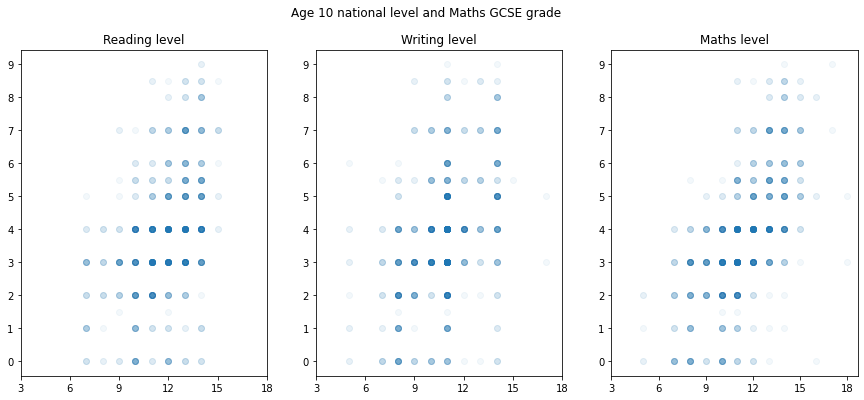

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,6))
plt.suptitle("Age 10 national level and Maths GCSE grade")
ax1.scatter(df["Re_num"],df["MathsAct"], alpha = 0.05)
ax2.scatter(df["Wr_num"],df["MathsAct"], alpha = 0.05)
ax3.scatter(df["Ma_num"],df["MathsAct"], alpha = 0.05)
ax1.set_title("Reading level")
ax2.set_title("Writing level")
ax3.set_title("Maths level")
ax1.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax2.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax3.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax1.set_xticks([3, 6, 9, 12, 15, 18])
ax2.set_xticks([3, 6, 9, 12, 15, 18])
ax3.set_xticks([3, 6, 9, 12, 15, 18])
plt.show()

Again, there is no obvious strong correlation between reading and writing age 10 result and maths GCSE grade. There is, however, a more noticeable correlation between maths level at age 10 and maths GCSE grade.

Again a Spearman correlation test will be carried out to determine any statistically significant correlation.

In [14]:
# convert all the necessary data from the dataframe into separate lists
# note that 'ma' refers to maths level at age 10, while 'maths' refers to maths GCSE
orig_read = df["Re_num"].tolist()
orig_wri = df["Wr_num"].tolist()
orig_ma = df["Ma_num"].tolist()
orig_maths = df["MathsAct"].tolist()

# create new lists containing only data for both age 10 and gcse where age 10 data is not missing
read = []
maths_r = []
for i in range(len(orig_read)):
    if orig_read[i] in level_dict.values():
        read.append(orig_read[i])
        maths_r.append(orig_maths[i])
        
writing = []
maths_w = []
for i in range(len(orig_wri)):
    if orig_wri[i] in level_dict.values():
        writing.append(orig_wri[i])
        maths_w.append(orig_maths[i])

ma = []      
maths_m = []
for i in range(len(orig_ma)):
    if orig_ma[i] in level_dict.values():
        ma.append(orig_ma[i])
        maths_m.append(orig_maths[i])           


In [15]:
# Spearman rho correlation test

print("Reading:")
coef, p = stats.spearmanr(read,maths_r)
print(f'Spearmans correlation coefficient: {round(coef, 3)}')
# interpret the significance
alpha = 0.05
if p > alpha:
    print(f'Samples are uncorrelated (fail to reject H0) p={round(p, 3)}')
else:
    if p >= 0.00001:
        print(f'Samples are correlated (reject H0) p={round(p*100, 3)}%')
    else:
        print(f'Samples are correlated (reject H0) p<0.001%')
    
print("\n")

print("Writing:")
coef, p = stats.spearmanr(writing,maths_w)
print(f'Spearmans correlation coefficient: {round(coef, 3)}')
# interpret the significance
alpha = 0.05
if p > alpha:
    print(f'Samples are uncorrelated (fail to reject H0) p={round(p, 3)}')
else:
    if p >= 0.00001:
        print(f'Samples are correlated (reject H0) p={round(p*100, 3)}%')
    else:
        print(f'Samples are correlated (reject H0) p<0.001%')
    
print("\n")

print("Maths:")
coef, p = stats.spearmanr(ma,maths_m)
print(f'Spearmans correlation coefficient: {round(coef, 3)}')
# interpret the significance
alpha = 0.05
if p > alpha:
    print(f'Samples are uncorrelated (fail to reject H0) p={round(p, 3)}')
else:
    if p >= 0.00001:
        print(f'Samples are correlated (reject H0) p={round(p*100, 3)}%')
    else:
        print(f'Samples are correlated (reject H0) p<0.001%')

Reading:
Spearmans correlation coefficient: 0.442
Samples are correlated (reject H0) p<0.001%


Writing:
Spearmans correlation coefficient: 0.423
Samples are correlated (reject H0) p<0.001%


Maths:
Spearmans correlation coefficient: 0.664
Samples are correlated (reject H0) p<0.001%


The results again show a statistically significant correlation between all age 10 results and maths GCSE grade. For maths GCSE grade the reading and writing age 10 results are again moderately correlated, however the maths age 10 result is strongly correlated with the maths GCSE grade.

**PP, EAL, and SEN compared to GCSE grades**

Now, let's consider whether Pupil Premium (PP), English as an Additional Language (EAL), or Special Educational Needs (SEN) could also predict maths and English GCSE grades.



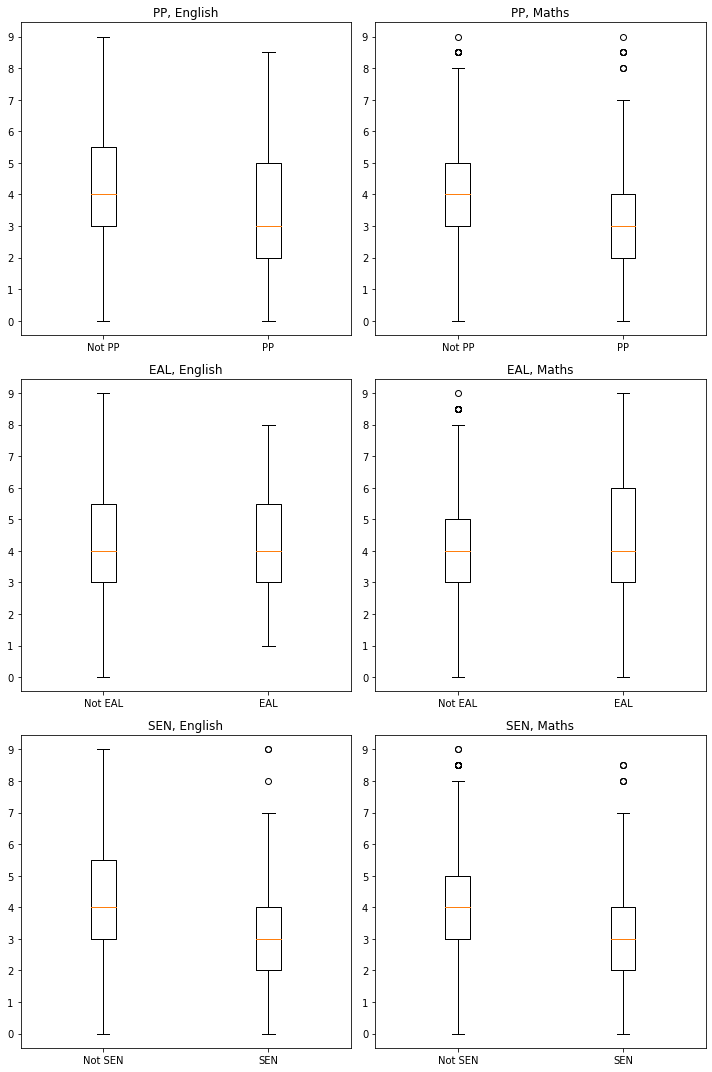

In [16]:
fig, axs = plt.subplots(3, 2, figsize=(10,15))

axs[0, 0].boxplot((df['EngAct'][df['PP']==0], df['EngAct'][df['PP']==1]), labels = ['Not PP', 'PP'])
axs[0, 0].set_title("PP, English")
axs[0, 0].set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
axs[1, 0].boxplot((df['EngAct'][df['EAL']==0], df['EngAct'][df['EAL']==1]), labels = ['Not EAL', 'EAL'])
axs[1, 0].set_title("EAL, English")
axs[1, 0].set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
axs[2, 0].boxplot((df['EngAct'][df['SEN']==0], df['EngAct'][df['SEN']==1]), labels = ['Not SEN', 'SEN'])
axs[2, 0].set_title("SEN, English")
axs[2, 0].set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

axs[0, 1].boxplot((df['MathsAct'][df['PP']==0], df['MathsAct'][df['PP']==1]), labels = ['Not PP', 'PP'])
axs[0, 1].set_title("PP, Maths")
axs[0, 1].set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
axs[1, 1].boxplot((df['MathsAct'][df['EAL']==0], df['MathsAct'][df['EAL']==1]), labels = ['Not EAL', 'EAL'])
axs[1, 1].set_title("EAL, Maths")
axs[1, 1].set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
axs[2, 1].boxplot((df['MathsAct'][df['SEN']==0], df['MathsAct'][df['SEN']==1]), labels = ['Not SEN', 'SEN'])
axs[2, 1].set_title("SEN, Maths")
axs[2, 1].set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

fig.tight_layout()

These boxplots show that both students who count as pupil premium or have any form of SEN appear to do slightly worse than their peers while students with English as an Additional Language do not appear to be affected. Note that these visuals do not include any overlap between students who are both SEN and pupil premium.

However, it is again clear that despite pupil premium and SEN students doing worse on average, there is still a high level of spread.

Let's conduct 4 statistical tests to determine whether students achieve a signicant difference in grade based on whether they are SEN or PP in either maths or English GCSE. A Mann-Whitney U test will be used as the GCSE grade data is oridnal.

In [17]:
# import scipy.stats as stats

# print(stats.ttest_ind(df['EngAct'][df['SEN'] == 0], df['EngAct'][df['SEN'] == 1]))

print("PP, English:")
# conduct mann-whitney u test to find u and p values
u, p = stats.mannwhitneyu(df['EngAct'][df['PP'] == 0], df['EngAct'][df['PP'] == 1], alternative='two-sided')
print(f'Mann-Whitney U: {round(u, 3)}')
# interpret the significance
alpha = 0.05
if p > alpha:
    print(f'Samples are not statistcially different (fail to reject H0) p={round(p*100, 3)}%')
else:
    if p >= 0.00001:
        print(f'Samples are statistically different (reject H0) p={round(p*100, 3)}%')
    else:
        print(f'Samples are statistically different (reject H0) p<0.001%')

print("\n")

print("PP, Maths:")
# conduct mann-whitney u test to find u and p values
u, p = stats.mannwhitneyu(df['MathsAct'][df['PP'] == 0], df['MathsAct'][df['PP'] == 1], alternative='two-sided')
print(f'Mann-Whitney U: {round(u, 3)}')
# interpret the significance
alpha = 0.05
if p > alpha:
    print(f'Samples are not statistcially different (fail to reject H0) p={round(p*100, 3)}%')
else:
    if p >= 0.00001:
        print(f'Samples are statistically different (reject H0) p={round(p*100, 3)}%')
    else:
        print(f'Samples are statistically different (reject H0) p<0.001%')

print('\n')

print("SEN, English:")
# conduct mann-whitney u test to find u and p values
u, p = stats.mannwhitneyu(df['EngAct'][df['SEN'] == 0], df['EngAct'][df['SEN'] == 1], alternative='two-sided')
print(f'Mann-Whitney U: {round(u, 3)}')
# interpret the significance
alpha = 0.05
if p > alpha:
    print(f'Samples are not statistcially different (fail to reject H0) p={round(p*100, 3)}%')
else:
    if p >= 0.00001:
        print(f'Samples are statistically different (reject H0) p={round(p*100, 3)}%')
    else:
        print(f'Samples are statistically different (reject H0) p<0.001%')

print('\n')

print("SEN, Maths:")
# conduct mann-whitney u test to find u and p values
u, p = stats.mannwhitneyu(df['MathsAct'][df['SEN'] == 0], df['MathsAct'][df['SEN'] == 1], alternative='two-sided')
print(f'Mann-Whitney U: {round(u, 3)}')
# interpret the significance
alpha = 0.05
if p > alpha:
    print(f'Samples are not statistcially different (fail to reject H0) p={round(p*100, 3)}%')
else:
    if p >= 0.00001:
        print(f'Samples are statistically different (reject H0) p={round(p*100, 3)}%')
    else:
        print(f'Samples are statistically different (reject H0) p<0.001%')



PP, English:
Mann-Whitney U: 151773.5
Samples are statistically different (reject H0) p<0.001%


PP, Maths:
Mann-Whitney U: 152402.5
Samples are statistically different (reject H0) p<0.001%


SEN, English:
Mann-Whitney U: 131346.5
Samples are statistically different (reject H0) p<0.001%


SEN, Maths:
Mann-Whitney U: 130932.5
Samples are statistically different (reject H0) p<0.001%


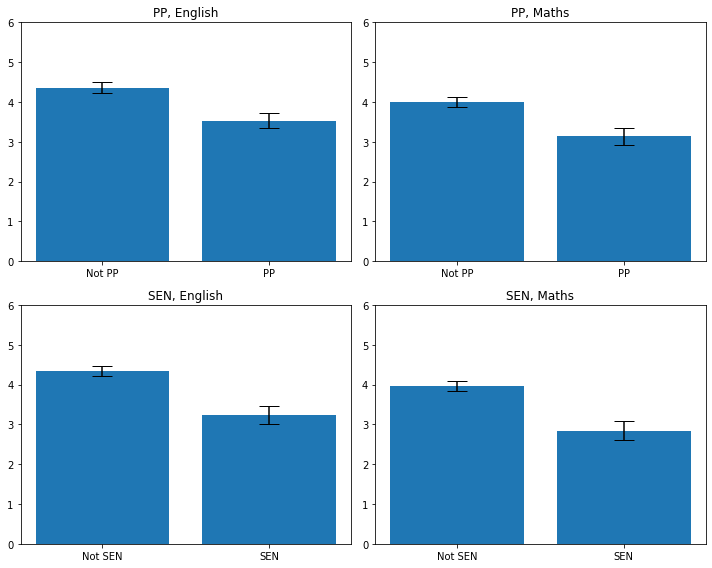

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))

# English GCSE grade
# finding the 95% confidence interval and adding it to bar chart
a, b = stats.t.interval(alpha=0.95, df=len(df['EngAct'][df['PP'] == 0])-1, loc=np.mean(df['EngAct'][df['PP'] == 0]), scale=stats.sem(df['EngAct'][df['PP'] == 0]))
c, d = stats.t.interval(alpha=0.95, df=len(df['EngAct'][df['PP'] == 1])-1, loc=np.mean(df['EngAct'][df['PP'] == 1]), scale=stats.sem(df['EngAct'][df['PP'] == 1]))
axs[0, 0].bar(['Not PP', 'PP'], [df['EngAct'][df['PP']==0].mean(), df['EngAct'][df['PP']==1].mean()], yerr = [(b-a)/2, (d-c)/2], capsize = 10)
axs[0, 0].set_title("PP, English")
axs[0, 0].set_yticks([0, 1, 2, 3, 4, 5, 6])
a, b = stats.t.interval(alpha=0.95, df=len(df['EngAct'][df['SEN'] == 0])-1, loc=np.mean(df['EngAct'][df['SEN'] == 0]), scale=stats.sem(df['EngAct'][df['SEN'] == 0]))
c, d = stats.t.interval(alpha=0.95, df=len(df['EngAct'][df['SEN'] == 1])-1, loc=np.mean(df['EngAct'][df['SEN'] == 1]), scale=stats.sem(df['EngAct'][df['SEN'] == 1]))
axs[1, 0].bar(['Not SEN', 'SEN'], [df['EngAct'][df['SEN']==0].mean(), df['EngAct'][df['SEN']==1].mean()], yerr = [(b-a)/2, (d-c)/2], capsize = 10)
axs[1, 0].set_title("SEN, English")
axs[1, 0].set_yticks([0, 1, 2, 3, 4, 5, 6])

# repeated for maths GCSE grade
a, b = stats.t.interval(alpha=0.95, df=len(df['MathsAct'][df['PP'] == 0])-1, loc=np.mean(df['MathsAct'][df['PP'] == 0]), scale=stats.sem(df['MathsAct'][df['PP'] == 0]))
c, d = stats.t.interval(alpha=0.95, df=len(df['MathsAct'][df['PP'] == 1])-1, loc=np.mean(df['MathsAct'][df['PP'] == 1]), scale=stats.sem(df['MathsAct'][df['PP'] == 1]))
axs[0, 1].bar(['Not PP', 'PP'], [df['MathsAct'][df['PP']==0].mean(), df['MathsAct'][df['PP']==1].mean()], yerr = [(b-a)/2, (d-c)/2], capsize = 10)
axs[0, 1].set_title("PP, Maths")
axs[0, 1].set_yticks([0, 1, 2, 3, 4, 5, 6])
a, b = stats.t.interval(alpha=0.95, df=len(df['MathsAct'][df['SEN'] == 0])-1, loc=np.mean(df['MathsAct'][df['SEN'] == 0]), scale=stats.sem(df['MathsAct'][df['SEN'] == 0]))
c, d = stats.t.interval(alpha=0.95, df=len(df['MathsAct'][df['SEN'] == 1])-1, loc=np.mean(df['MathsAct'][df['SEN'] == 1]), scale=stats.sem(df['MathsAct'][df['SEN'] == 1]))
axs[1, 1].bar(['Not SEN', 'SEN'], [df['MathsAct'][df['SEN']==0].mean(), df['MathsAct'][df['SEN']==1].mean()], yerr = [(b-a)/2, (d-c)/2], capsize = 10)
axs[1, 1].set_title("SEN, Maths")
axs[1, 1].set_yticks([0, 1, 2, 3, 4, 5, 6])

fig.tight_layout()

The bar charts above show the mean and 95% confidence interval for each sample of data.

They and the Mann-Whitney U test show that GCSE grades signigicantly differ for both SEN and PP students in both maths and English. 

**Interpretation and Conclusion**

The findings in terms of PP and SEN are interesting as these are pupils whose schools may already receive funding aimed at supporting these students specifically yet they are still receiving lower grades than those without. (Schools receive additional funding for all PP students but only SEN students who have an Education, Health and Care Plan (EHCP).)

Given PP and SEN students do worse even with funding aimed at them it is surprising that this is not taken into consideration by the government when predicting GCSE grades. A school's Progress8 score (a comparison between how well students did at age 10 vs how well they did at GCSE), may therefore be worse in schools with higher numbers of PP and SEN students.

As reading, writing, and maths levels at age 10 were correlated with maths and English GCSE results it is understandable that they will be used as a basis for a predicted GCSE grade. But that does not mean that they should be used as the sole predictor, as some schools have been, in setting students with unattainably high target grades or discouragingly low target grades in the lead up to GCSE exams.


Final note: As has previously been mentioned there are many inconsistencies in the data leading all analyses to be questioned as to their reliability (e.g. levels at age 10 being left without the latter part of the level, and GCSE grade data having decimal values). An extra important note is that as already mentioned the data for age 10 results is from the old national level system, replaced in 2015. This data and analysis does not consider the new primary school grading system and whether this would still correlate with GCSE results.

Thank you for reading this notebook (if you have got this far!). 

I would appreciate any comments if you have suggestions for other data that could be analysed in a similar way or if there are any mistakes in my analysis above.